<a href="https://colab.research.google.com/github/e-charb/Notebooks/blob/main/cbf_movie_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendations!

Let's create a movie recommendation system using a content-based filtering approach. This technique generates recommendations based on the interests of the users. For a great introduction to this topic, check out [this course from  Google](https://developers.google.com/machine-learning/recommendation/content-based/basics).


We'll be using the [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data) containing metadata on over 45,000 movies.

To start, we'll import some libraries to help us read and work with the data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

#Extract

In [ ]:
df_metadata = pd.read_csv('/content/drive/MyDrive/data_science/movie_recommendation/movie_data/movies_metadata.csv')
df_credits = pd.read_csv('/content/drive/MyDrive/data_science/movie_recommendation/movie_data/credits.csv',dtype={'id':'object'})
df_keywords = pd.read_csv('/content/drive/MyDrive/data_science/movie_recommendation/movie_data/keywords.csv',dtype={'id':'object'})

In [ ]:
df_metadata.shape

(45466, 24)

In [ ]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
df_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [ ]:
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  object
 1   keywords  46419 non-null  object
dtypes: object(2)
memory usage: 725.4+ KB


#Transform

In this section, we will get our data ready for use. This includes:


*   Joining the datasets
*   Converting datatypes where appropriate
*   Filtering the data
*   Replacing values where necessary
*   Removing duplicate rows



## Joining the datasets

Let's combine these datasets on the 'id' column:

In [ ]:
df2 = pd.merge(pd.merge(df_metadata,df_credits,how='left',on='id'),df_keywords,how='left',on='id')

In [ ]:
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46632 entries, 0 to 46631
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  46632 non-null  object 
 1   belongs_to_collection  4577 non-null   object 
 2   budget                 46632 non-null  object 
 3   genres                 46632 non-null  object 
 4   homepage               8012 non-null   object 
 5   id                     46632 non-null  object 
 6   imdb_id                46615 non-null  object 
 7   original_language      46621 non-null  object 
 8   original_title         46632 non-null  object 
 9   overview               45637 non-null  object 
 10  popularity             46626 non-null  object 
 11  poster_path            46233 non-null  object 
 12  production_companies   46628 non-null  object 
 13  production_countries   46628 non-null  object 
 14  release_date           46544 non-null  object 
 15  re

## Data Type Conversion + Dataset Filtering


Here's the plan for fixing data types for each column:


*   If it's supposed to be a non-string feature (list, dictionary, float, etc.), we run our safe_literal_eval function on that column and look at the problematic rows. We can decide what to do about these failed rows case by case.
*   While going through the list of columns, we will drop columns that won't be useful for this project.

After this, we can look at how to deal with null values.

In [ ]:
def safe_literal_eval(df, columns):
  """
  Attempts to apply ast.literal_eval to given columns in each row of the DataFrame.
  Skips and logs rows where parsing fails.

  Parameters:
  df (pd.DataFrame): The DataFrame to process.
  columns (list): List of column names to apply literal_eval to.

  Returns:
  tuple: (updated_df, failed_rows)
  """
  failed_rows = []

  for idx, row in df.iterrows():
    for col in columns:
      val = row[col]
      if isinstance(val, str):
        try:
          df.at[idx, col] = literal_eval(val)
        except (ValueError, SyntaxError):
          failed_rows.append((idx, col, val))
      # If it's already list/dict/etc, skip conversion
  return df, failed_rows

In [ ]:
# checking failed conversion for 'adult' column
_, failed_rows = safe_literal_eval(df2,['adult'])
failed_rows

[(19846, 'adult', ' - Written by Ørnås'),
 (29678,
  'adult',
  ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.'),
 (35974,
  'adult',
  ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.')]

These values don't belong in the 'adult' column. We'll drop these rows.

In [ ]:
# dropping problematic rows where conversion failed:
df2.drop([x[0] for x in failed_rows], inplace=True)

For the curious readers, this column states whether or not the movie is an *Adult Movie*, if you know what I mean. Let's filter our dataframe to remove all adult movies, then remove the 'adult' column.

In [ ]:
df2 = df2[df2['adult'] == False]
df2.drop('adult', axis=1, inplace=True)

In [ ]:
# checking failed conversion for 'belongs_to_collection' column
_, failed_rows = safe_literal_eval(df2,['belongs_to_collection'])
failed_rows

[]

In [ ]:
# checking failed conversion for 'budget' column
_, failed_rows = safe_literal_eval(df2,['budget'])
df2['budget'] = df2['budget'].astype(float)
failed_rows

[]

In [ ]:
# checking failed conversion for 'genres' column
_, failed_rows = safe_literal_eval(df2,['genres'])
failed_rows

[]

In [ ]:
# dropping 'homepage' column, we won't be using it for this project
df2.drop('homepage', axis=1, inplace=True)

In [ ]:
# checking failed conversion for 'popularity' column
_, failed_rows = safe_literal_eval(df2,['popularity'])
df2['popularity'] = df2['popularity'].astype(float)
failed_rows

[]

In [ ]:
df2['popularity'].describe()

,popularity
count,46136.000000
mean,2.913243
std,5.969999
min,0.000000
25%,0.387829
50%,1.127478
75%,3.663214
max,547.488298


In [ ]:
len(df2[df2['popularity']<1])

21561

I don't think this 'popularity' column will be useful to us. Let's drop it.

In [ ]:
# dropping 'popularity' column
df2.drop('popularity', axis=1, inplace=True)

In [ ]:
# dropping 'poster_path' column
df2.drop('poster_path', axis=1, inplace=True)

In [ ]:
# checking failed conversion for 'production_companies' column
_, failed_rows = safe_literal_eval(df2,['production_companies'])
failed_rows

[]

In [ ]:
# extracting production company names from 'production_companies' column
df2['production_companies'] = df2['production_companies'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if isinstance(d, dict)]
)

In [ ]:
# checking failed conversion for 'production_countries' column
_, failed_rows = safe_literal_eval(df2,['production_countries'])
failed_rows

[]

In [ ]:
# extracting countries from 'production_countries' column
df2['production_countries'] = df2['production_countries'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if isinstance(d, dict)]
)

In [ ]:
# checking failed conversion for 'revenue' column
_, failed_rows = safe_literal_eval(df2,['revenue'])
failed_rows

[]

In [ ]:
# checking failed conversion for 'runtime' column
_, failed_rows = safe_literal_eval(df2,['runtime'])
failed_rows

[]

In [ ]:
# checking failed conversion for 'spoken_languages' column
_, failed_rows = safe_literal_eval(df2,['spoken_languages'])
failed_rows

[]

In [ ]:
# Filtering our dataframe to only include released movies, then dropping 'status' column
df2 = df2[df2['status']=='Released']
df2.drop('status', axis=1, inplace=True)

In [ ]:
# Dropping 'original_title' column. The existing 'title' column is good enough for us.
df2.drop('original_title', axis=1, inplace=True)

In [ ]:
# Dropping 'video' column. This column contains boolean values stating whether or not the movie was made from stitched together cut scenes.
df2.drop('video', axis=1, inplace=True)

In [ ]:
# checking failed conversion for 'cast' column
_, failed_rows = safe_literal_eval(df2,['cast'])
failed_rows

[]

In [ ]:
# Extracting names from 'cast' column

df2['cast'] = df2['cast'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if isinstance(d, dict)]
)

In [ ]:
# checking failed conversion for 'crew' column
_, failed_rows = safe_literal_eval(df2,['crew'])
failed_rows

[]

In [ ]:
# checking failed conversion for 'keywords' column
_, failed_rows = safe_literal_eval(df2,['keywords'])
failed_rows

[]

In [ ]:
# Extracting keywords from 'keywords' column
df2['keywords'] = df2['keywords'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if isinstance(d, dict)]
)

Cool! At this point, each column should be of the correct data type.

Now it's time to check for null and incorrect values.

## Dealing with Missing Values and Duplicate Rows

When dealing with missing data, there are several possible options:


*   **Deletion**: remove the rows with missing data
*   **Imputation**: This could mean different things. If a column contains string type data, we might replace NaN with an empty string. We could do the equivalent replacement operation for list columns. For columns containing dictionaries, we might extract the relevant key, value, or key/value pair and replace the dictionary with a string containing the innner inforation. *Alternatively*, we can do some web scraping and replace NaN values with the sraped results. For numerical data, we might web scrape or replace NaN values with some statistic (mean,mode, etc.) calculated from existing column data.

We should also make sure data in each column looks the way it should. For example, each 'imdb_id' should be of the form 'ttxxxxxxx' where each 'x' is a digit.

Let's get into it:

In [ ]:
# web scraping tools
import requests
from bs4 import BeautifulSoup
import time
import random
import re

In [ ]:
# Gets the imdb html for a movie using imdb_id
def get_soup(imdb_id):
  url = f"https://www.imdb.com/title/{imdb_id}"
  headers = {
    "User-Agent": "Mozilla/5.0"  # Avoid blocks
  }
  time.sleep(random.randint(0, 3)) # Avoid blocks
  try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()
  except requests.RequestException as e:
    print(f"Request failed: {e}")
    return None

  soup = BeautifulSoup(response.text, 'html.parser')
  return soup

In [ ]:
def extract_from_html(soup, tag, attrs=None, multiple=False, get_text=True):
  """
  Extract data from HTML based on tag and attributes.

  Parameters:
  - soup: BeautifulSoup object
  - tag: HTML tag (string), e.g., 'div', 'span', 'a'
  - attrs: dict of HTML attributes, e.g., {'class': 'title_wrapper'}
  - multiple: bool, whether to return all matches or just the first
  - get_text: bool, whether to return .text or raw element(s)

  Returns:
  - Single value or list, depending on 'multiple'
  """
  # if not language_section:                            # These 3 lines are from an old scraping function.
  #   print("Language section not found.")              # I think we delete these lines.
  #   return None
  if multiple:
    elements = soup.find_all(tag, attrs=attrs)
    return [el.get_text(strip=True) if get_text else el for el in elements]
  else:
    element = soup.find(tag, attrs=attrs)
    if element:
      return element.get_text(strip=True) if get_text else element
    return None

In [ ]:
# Extracting the collection name when it exists, replacing NaN with 'no'
df2['belongs_to_collection'] = df2['belongs_to_collection'].apply(lambda x: x['name'] if pd.notnull(x) else '')

In [ ]:
df2['belongs_to_collection']

,belongs_to_collection
0,Toy Story Collection
1,no
2,Grumpy Old Men Collection
3,no
4,Father of the Bride Collection
...,...
46627,no
46628,no
46629,no
46630,no


In [ ]:
df2['genres'].isna().value_counts()

,count
genres,
False,46165


In [ ]:
# Extracting genres from lists of dicts
df2['genres'] = df2['genres'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if isinstance(d, dict)]
)

In [ ]:
# Dropping rows without an 'imdb_id'
print('dropping rows:',df2[df2['imdb_id'].isna()].index.tolist())
df2.drop(df2[df2['imdb_id'].isna()].index.tolist(), inplace=True)

dropping rows: [9005, 13841, 13905, 17498, 19075, 19438, 20928, 21065, 22053, 23890, 33937, 38103, 41966, 42989, 46233]


In [ ]:
# Confirming the length of each imdb_id is 9
len(df2[df2['imdb_id'].apply(len)==9]) == len(df2)

True

Next we have the 'original_language' column, which has 10 missing values. This is actually my second time working with this dataset, and I learned a lot from my first go at it. One of the lessons I learned is to make sure to inspect the dataset carefully before resorting to replacing missing values with web scraped results. It turns out that there is a related column named 'spoken_languages', which contains the ISO 639-1 (two letter) language codes I need. We'll use these to replace our missing values.

In [ ]:
lang_codes_list = df2[df2['original_language'].isna()]['spoken_languages'].to_list()      # List of lists containing language codes
lang_codes = [x[0]['iso_639_1'] for x in lang_codes_list]                                 # Replacement values gathered from 'spoken_languages'
lang_codes_idx = df2[df2['original_language'].isna()]['spoken_languages'].index.to_list() # Indices of missing values

# replacing missing 'original_language' value:
for idx, code in zip(lang_codes_idx, lang_codes):
  df2.at[idx, 'original_language'] = code

In [ ]:
df2.loc[lang_codes_idx,'original_language']

,original_language
19690,de
21736,en
22972,en
32319,en
38555,cs
42204,ur
43029,xx
45214,fr
45567,sv
45733,de


In [ ]:
# Replacing missing values in 'overview' column with empty string
df2['overview'] = df2['overview'].fillna('')

In [ ]:
missing_rd_idx = df2[df2['release_date'].isna()].index.to_list() # Indices of missing values
missing_rd_imdb_id = df2.loc[missing_rd_idx,'imdb_id'].to_list() # imdb_id's for corresponding missing values

In [ ]:
scraped_rd = [] # List to be populated with missing release_dates

# Scraping imdb for missing release_date values
for id in missing_rd_imdb_id:
  soup = get_soup(id) # html of imdb page
  if extract_from_html(soup, tag='a',attrs={'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link',
                                            'href':f'/title/{id}/releaseinfo/?ref_=tt_dt_rdat'}):
    rd_str = extract_from_html(soup, tag='a',attrs={'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link',
                                                    'href':f'/title/{id}/releaseinfo/?ref_=tt_dt_rdat'}).split(' (')[0]
    scraped_rd.append(rd_str)
  else:
    print(f'date for f{id} not found')
    scraped_rd.append(None)


May 9, 1996
September 25, 1992
June 21, 2000
February 26, 2007
September 2007
December 12, 1992
January 12, 2005
October 17, 1978
October 23, 2010
September 16, 1993
March 19, 2003
April 15, 1993
April 6, 1925
April 9, 2008
October 31, 1980
date for ftt0185048 not found
April 10, 2009
March 20, 2007
January 18, 2013
March 12, 2013
date for ftt0839851 not found
October 30, 1987
March 11, 2013
October 6, 1999
August 10, 2004
October 12, 2008
May 11, 2004
2002
May 21, 2007
January 6, 2008
March 13, 2015
December 14, 1978
February 3, 2012
July 23, 2013
November 9, 2014
June 14, 2014
October 7, 2003
November 2007
December 6, 2001
June 16, 1999
June 11, 1997
December 26, 2015
April 30, 2011
May 16, 2013
February 10, 2003
date for ftt0222730 not found
November 6, 2015
2012
June 6, 2016
July 5, 2016
July 3, 2016
March 5, 2023
July 1, 2016
January 18, 2013
date for ftt0250944 not found
date for ftt2282697 not found
March 26, 2015
January 7, 2010
September 18, 2012
February 11, 2017
October 27, 

In [ ]:
# Replacing missing release_date values with scraped values
for idx, rd in zip(missing_rd_idx, scraped_rd):
  df2.at[idx, 'release_date'] = rd

75

In [ ]:
# Creating a new column release_year
df2['release_year'] = df2['release_date'].astype('datetime64[ns]').apply(lambda date: date.year)

scraped_year = [int(x[-4:]) if isinstance(x,str) else None for x in scraped_rd] # List of release_year values for missing entries

# Replacing missing 'release_year' values:
for idx, year in zip(missing_rd_idx, scraped_year):
  df2.at[idx, 'release_year'] = year

In [ ]:
# Dropping rows without 'release_year'
print('dropping rows:',df2[df2['release_year'].isna()].index.tolist())
df2.drop(df2[df2['release_year'].isna()].index.tolist(), inplace=True)

dropping rows: [20423, 22156, 40014, 42226, 42271]


In [ ]:
# Dropping the 'release_date' column, since we now have 'release_year' column
df2 = df2.drop('release_date', axis=1)

In [ ]:
# Confirming no missing release_year values
df2['release_year'].isna().sum()

np.int64(0)

In [ ]:
scraped_runtimes = []                                                           # List to be populated with missing release_dates
missing_runtime_imdb_ids = df2[df2['runtime'].isna()]['imdb_id'].tolist()       # List containing imdb_ids for missing runtime rows
missing_runtime_idx = df2[df2['runtime'].isna()].index.tolist()                 # List containing indices for missing runtime rows


# Scraping imdb for missing release_date values
for id in missing_runtime_imdb_ids:
  soup = get_soup(id) # html of imdb page
  runtime_attrs = {'class':'ipc-inline-list__item',
                   'role':'presentation'}
  if extract_from_html(soup, tag='li',attrs=runtime_attrs):
    runtime_candidates = extract_from_html(soup, tag='li',attrs=runtime_attrs,multiple=True)
    for candidate in runtime_candidates:
      # Prefer strings that contain both 'h' and 'm'
      match = re.match(r'^(\d+)\s*h\s*(\d+)\s*m$', candidate)
      if match:
        hours = float(match.group(1))
        minutes = float(match.group(2))
        runtime = hours * 60 + minutes
        print(f'runtime for imdb_id {id} found: {runtime}')
        scraped_runtimes.append(runtime)

      # Fallback: match just minutes like "95m"
      match = re.match(r'^(\d+)\s*m$', candidate)
      if match:
        runtime = float(match.group(1))
        print(f'runtime for imdb_id {id} found: {runtime}')
        scraped_runtimes.append(runtime)
  else:
    print(f'runtime for f{id} not found')
    scraped_runtimes.append(None)

runtime for imdb_id tt0117312 found: 95.0
runtime for imdb_id tt0116485 found: 86.0
runtime for imdb_id tt0118026 found: 102.0
runtime for imdb_id tt0112865 found: 93.0
runtime for imdb_id tt0094822 found: 90.0
runtime for imdb_id tt0387701 found: 93.0
runtime for imdb_id tt0047338 found: 90.0
runtime for imdb_id tt0064203 found: 92.0
runtime for imdb_id tt1404661 found: 110.0
runtime for imdb_id tt0087587 found: 90.0
runtime for imdb_id tt0109744 found: 88.0
runtime for imdb_id tt0484064 found: 93.0
runtime for imdb_id tt0154750 found: 117.0
runtime for imdb_id tt0343624 found: 94.0
runtime for imdb_id tt0103228 found: 87.0
runtime for imdb_id tt0366808 found: 88.0
runtime for imdb_id tt0189102 found: 90.0
runtime for imdb_id tt0105087 found: 105.0
runtime for imdb_id tt0107903 found: 58.0
runtime for imdb_id tt0107903 found: 58.0
runtime for imdb_id tt0236398 found: 20.0
runtime for imdb_id tt0236398 found: 20.0
runtime for imdb_id tt0339482 found: 90.0
runtime for imdb_id tt0095764 

In [ ]:
# Replacing missing runtime values with scraped values
for idx, runtime in zip(missing_runtime_idx, scraped_runtimes):
  df2.at[idx, 'runtime'] = runtime

In [ ]:
# Replacing missing values in 'tagline' column with empty string
df2['tagline'] = df2['tagline'].fillna('')

In [ ]:
# Dropping row with missing 'cast' value
df2.drop(df2[df2['cast'].isna()].index.tolist(), axis=0, inplace=True)

In [ ]:
# Checking for null values
df2.isna().sum()

,0
adult,0
belongs_to_collection,0
budget,0
genres,0
id,0
imdb_id,0
original_language,0
overview,0
popularity,0
production_companies,0


In [ ]:
# Dropping duplicate rows (sharing imdb_id)
df2 = df2.drop_duplicates(subset='imdb_id')

# Data Visualization

Now that we've cleaned our data, let's create some visualizations to better understand what we're working with:

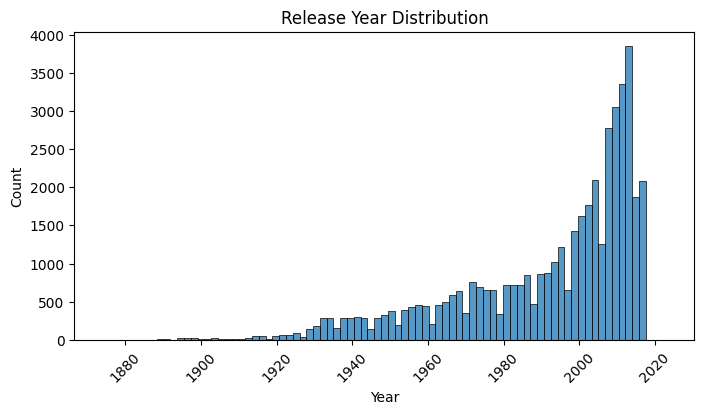

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(data=df2,x='release_year')
plt.title('Release Year Distribution')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()

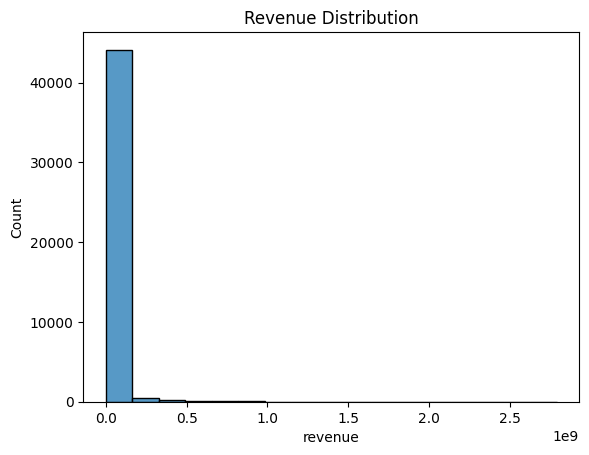

In [ ]:
sns.histplot(data=df2,x='revenue')
plt.title('Revenue Distribution')
plt.show()

In [ ]:
df2['revenue'].describe()

,revenue
count,4.495600e+04
mean,1.132960e+07
std,6.468021e+07
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.787965e+09


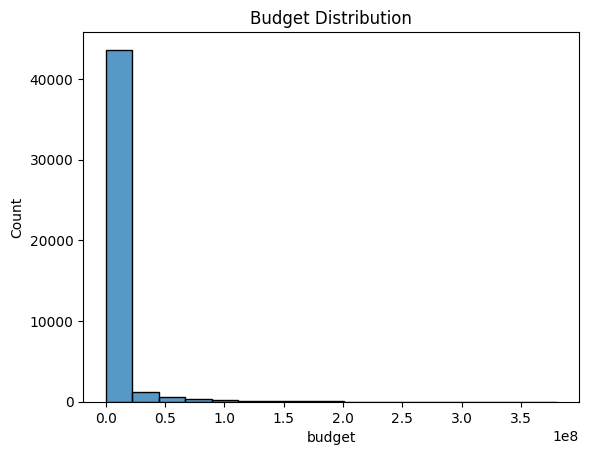

In [ ]:
sns.histplot(data=df2,x='budget')
plt.title('Budget Distribution')
plt.show()

In [ ]:
df2['budget'].describe()

,budget
count,4.614400e+04
mean,4.205747e+06
std,1.735934e+07
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.800000e+08


As we can see above, the vast majority of our budget and revenue values are 0. This is pretty disappointing, because I wanted to see the correlation between these features and average_rating. I'm going to drop these columns. Perhaps in the future, I'll create my own movie dataset.

In [ ]:
df2.drop('budget', axis=1, inplace=True)

In [ ]:
df2.drop('revenue', axis=1, inplace=True)

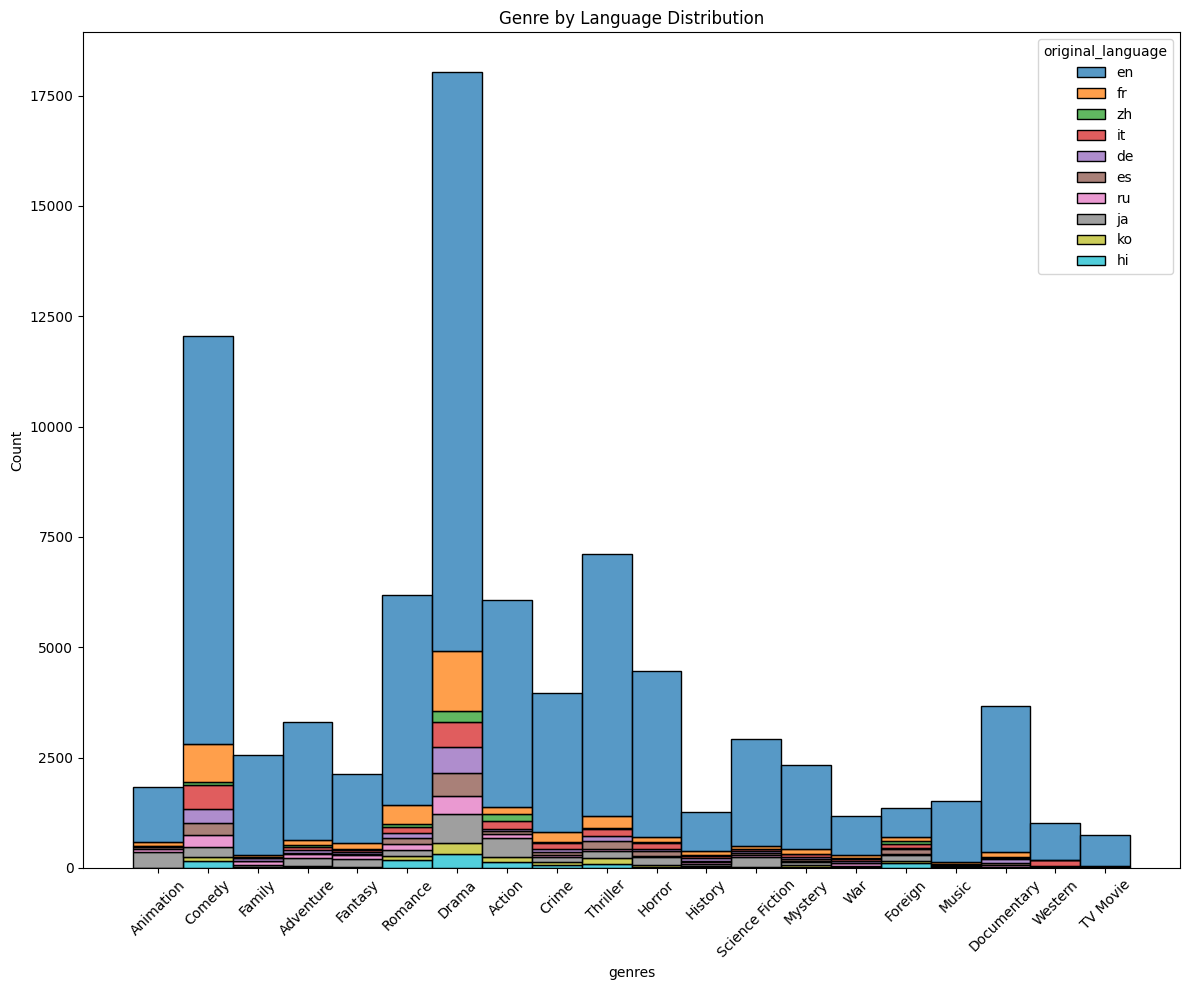

In [ ]:
plt.figure(figsize=(12,10))

# Step 1: Get top 10 languages
top_langs = df2['original_language'].value_counts().nlargest(10).index

# Step 2: Filter df2 to only those languages
df2_top_langs = df2[df2['original_language'].isin(top_langs)]

# Step 3: Explode genres & reset index
df2_top_langs_exploded = df2_top_langs.explode('genres').reset_index(drop=True)

# Step 4: Plot
sns.histplot(
    data=df2_top_langs_exploded,
    x='genres',
    hue='original_language',
    multiple='stack'
)

plt.xticks(rotation=45)
plt.title('Genre by Language Distribution')
plt.tight_layout()
plt.show()

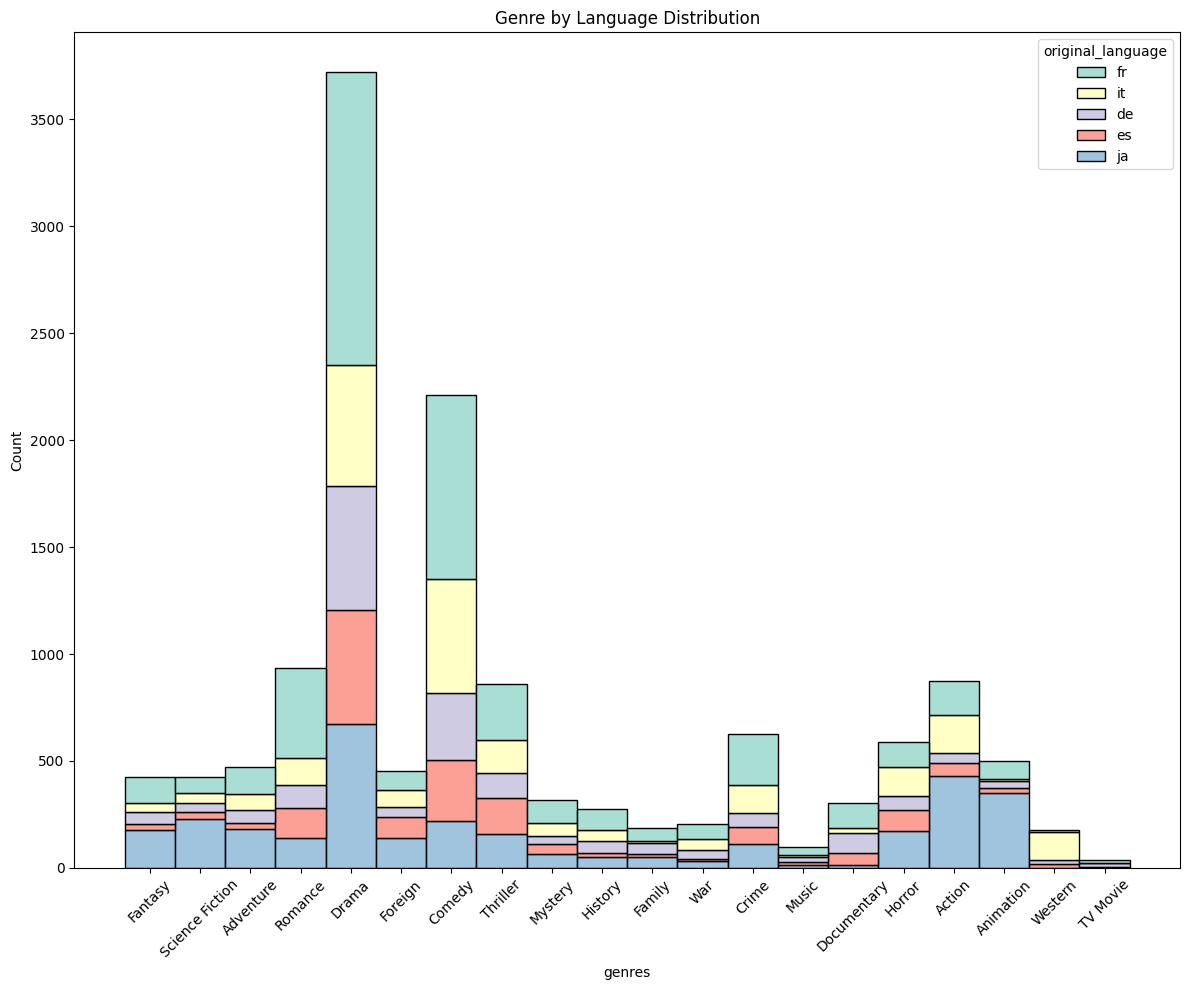

In [ ]:
plt.figure(figsize=(12,10))

# Step 1: Get indices of top 5 languages after english
top_langs = df2['original_language'].value_counts()[1:].nlargest(5).index

# Step 2: Filter df2 to only those languages
df2_top_langs = df2[df2['original_language'].isin(top_langs)]

# Step 3: Explode genres & reset index
df2_top_langs_exploded = df2_top_langs.explode('genres').reset_index(drop=True)

# Step 4: Plot
sns.histplot(
    data=df2_top_langs_exploded,
    x='genres',
    hue='original_language',
    palette='Set3',
    multiple='stack'
)

plt.xticks(rotation=45)
plt.title('Genre by Language Distribution')
plt.tight_layout()
plt.show()

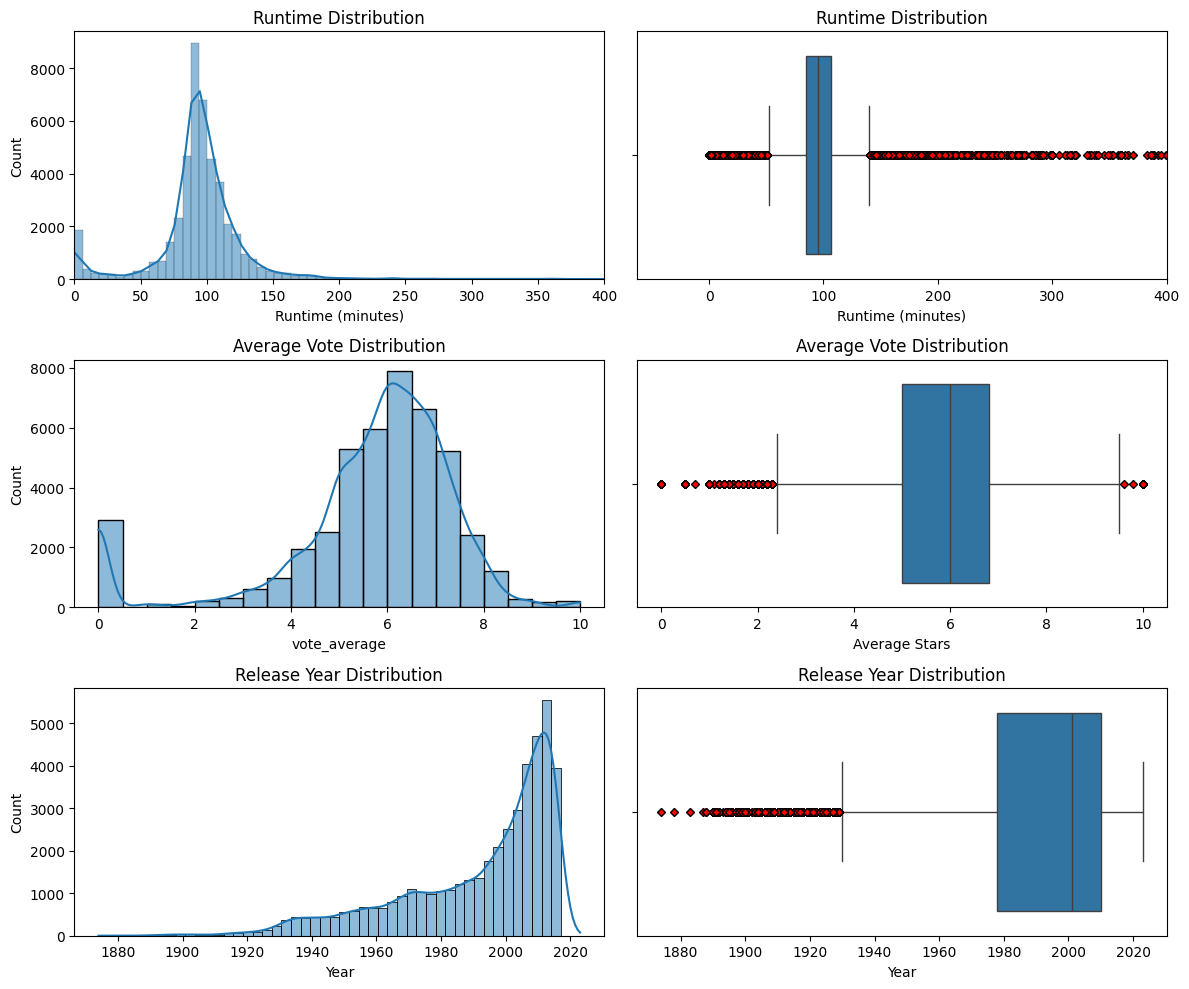

In [ ]:
# ['vote_average','vote_count','budget','revenue','runtime']

flierprops = dict(marker='D',  # Change marker shape to circle
                  markerfacecolor='red', # Change marker face color to red
                  markersize=4, # Increase marker size
                  linestyle='none', # Remove line connecting markers
                  markeredgecolor='black') # Set marker edge color

fig, axes = plt.subplots(3, 2, figsize=(12, 10)) # 3 rows, 2 columns

sns.histplot(data=df2,x='runtime',kde=True, bins=200,ax=axes[0][0])
axes[0][0].set_title('Runtime Distribution')
axes[0][0].set_xlim(0,400)
axes[0][0].set_xlabel('Runtime (minutes)')

sns.boxplot(data=df2, x='runtime', flierprops=flierprops,ax=axes[0][1])
axes[0][1].set_title('Runtime Distribution')
axes[0][1].set_xlabel('Runtime (minutes)')
axes[0][1].set_xlim(right=400)
axes[0][1].set_alpha(0.1)

sns.histplot(data=df2,x='vote_average',kde=True, bins=20, ax=axes[1][0])
axes[1][0].set_title('Average Vote Distribution')

sns.boxplot(data=df2, x='vote_average', flierprops=flierprops,ax=axes[1][1])
axes[1][1].set_title('Average Vote Distribution')
axes[1][1].set_xlabel('Average Stars')
# axes[1][1].plot(alpha=0.5)
# axes[1][1].set_ylim(top=400)

sns.histplot(data=df2,x='release_year',kde=True, bins=50,ax=axes[2][0])
axes[2][0].set_title('Release Year Distribution')
# axes[2][0].set_xlim(0,400)
axes[2][0].set_xlabel('Year')

sns.boxplot(data=df2, x='release_year', flierprops=flierprops,ax=axes[2][1])
axes[2][1].set_title('Release Year Distribution')
axes[2][1].set_xlabel('Year')
# axes[2][1].set_ylim(top=400)
axes[2][1].set_alpha(0.1)


plt.tight_layout() # Adjust layout to prevent overlapping

plt.show()

# Feature Engineering

In this section we'll do the following:
* Create a copy of our dataframe
* Engineer our features to make them more useful for recommendations
* Remove columns that won't be used as features in our recommendation system

In [ ]:
df_rec = df2.copy(deep=True) # Deep copy, changes to this copy won't be reflected in the original

In [ ]:
# Creates a 'Director' column, extracts director from 'crew' column
df_rec['Director'] = df_rec['crew'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if (isinstance(d, dict) and d['job'] == 'Director')]
)

In [ ]:
# Creates a 'Writers' column, extracts writers from 'crew' column
df_rec['Writers'] = df_rec['crew'].apply(
    lambda x: [d['name'] for d in (literal_eval(x) if isinstance(x, str) else x) if (isinstance(d, dict) and (d['job'] == 'Writer' or d['job'] == 'Screenplay'))]
)

In [ ]:
# Creating bins to group runtimes
time_bins = [-1,40,120,180,np.inf] # bins for film length
time_names = ['short_film','feature_film','longer_feature','epic_feature']
df_rec['runtime_bins'] = pd.cut(df_rec['runtime'], time_bins, labels=time_names)

df_rec['runtime_bins'] = df_rec['runtime_bins'].astype(str)

In [ ]:
# Creating new release_year feature: adding 'year_' to release_years value
df_rec['release_year_feat'] = df_rec['release_year'].apply(lambda year: f'year_{str(int(year))}')

In [ ]:
# Creating new vote_average feature: adding 'vote_' to floor of vote_average value
df_rec['vote_average_feat'] = df_rec['vote_average'].apply(lambda year: f'vote_{str(int(year))}')

In [ ]:
# Function to join elements of a list of strings
def join_list(x):
    if isinstance(x, list):
        return ' '.join(x)
    return str(x)

In [ ]:
list_to_str_cols = ['genres','production_companies','production_countries','cast','keywords','Director','Writers']

for col in list_to_str_cols:
  df_rec[f'{col}_str'] = df_rec[col].apply(join_list)   # Creating new features filled with joined elements of lists of strings

In [ ]:
cols_to_remove = ['genres','id','production_companies','production_countries','revenue','runtime','spoken_languages','vote_average','vote_count','cast','crew','keywords','release_year','Director','Writers']

# Dropping columns listed above
df_rec.drop(columns=cols_to_remove, axis=1, inplace=True)

# Creating a Collaborative Filtering Recommendation System

We'll make a new column that combines all of our hand selected features. This is what we will vectorize when creating our TF-IDF embeddings. There are just a few last things we need to take care of before we vectorize:

*   Convert to lowercase (prevent distinction between 'Cat' and 'cat')
*   Lemmatize (transform words to their base form)
*   Remove stop words (words that don't carry semantic meaning)

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

In [ ]:
# Creating combined_features column
df_rec['combined_features'] = (
    df_rec['belongs_to_collection'] + ' ' +
    df_rec['original_language'] + ' ' +
    df_rec['overview'] + ' ' +
    df_rec['tagline'] + ' ' +
    df_rec['title'] + ' ' +
    df_rec['runtime_bins'] + ' ' +
    df_rec['release_year_feat'] + ' ' +
    df_rec['vote_average_feat'] + ' ' +
    df_rec['genres_str'] + ' ' +
    df_rec['production_companies_str'] + ' ' +
    df_rec['production_countries_str'] + ' ' +
    df_rec['cast_str'] + ' ' +
    df_rec['keywords_str'] + ' ' +
    df_rec['Director_str'] + ' ' +
    df_rec['Writers_str']
)

# Converting to lowercase
df_rec['combined_features'] = df_rec['combined_features'].apply(str.lower)

# Lemmatizing
df_rec['combined_features'] = df_rec['combined_features'].apply(lemmatize_text)

In [ ]:
# Reordering columns just so it's easier on the eyes

df_rec = df_rec.loc[:, ['imdb_id', 'title', 'release_year_feat', 'belongs_to_collection', 'original_language', 'Director_str', 'Writers_str','cast_str', 'overview', 'tagline', 'runtime_bins',
 'vote_average_feat', 'genres_str', 'production_companies_str', 'production_countries_str', 'keywords_str', 'combined_features']]

In [ ]:
# Create TF-IDF Matrix

vectorizer = TfidfVectorizer(stop_words='english') # Built in stop words removal
X = vectorizer.fit_transform(df_rec['combined_features']) # Fits to and transforms data in one line

In [ ]:
# Gathers recommendations using movie title
def recommend_using_title(movie_title, df, X, top_n=10):
    # Find the index of the movie in the DataFrame
    idx = df[df['title'] == movie_title].index[0]

    # Compute cosine similarity between this movie and all others
    cosine_sim = cosine_similarity(X[idx], X).flatten()

    # Get indices of top N similar movies (excluding itself)
    similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]

    # Return the most similar movies
    return df.iloc[similar_indices]

# Testing the Recommendation System

In [ ]:
df_rec[df_rec['imdb_id']=='tt0103064']

,imdb_id,title,release_year_feat,belongs_to_collection,original_language,Director_str,Writers_str,cast_str,overview,tagline,runtime_bins,vote_average_feat,genres_str,production_companies_str,production_countries_str,keywords_str,combined_features
582,tt0103064,Terminator 2: Judgment Day,year_1991,The Terminator Collection,en,James Cameron,James Cameron William Wisher Jr.,Arnold Schwarzenegger Linda Hamilton Robert Pa...,Nearly 10 years have passed since Sarah Connor...,It's nothing personal.,longer_feature,vote_7,Action Thriller Science Fiction,Lightstorm Entertainment Pacific Western Canal...,France United States of America,cyborg shotgun post-apocalyptic dystopia moral...,the terminator collection en nearly 10 year ha...


In [ ]:
# Testing recommendations using a movie title
recommend_using_title('Toy Story',df_rec,X)

,imdb_id,title,release_year_feat,belongs_to_collection,original_language,Director_str,Writers_str,cast_str,overview,tagline,runtime_bins,vote_average_feat,genres_str,production_companies_str,production_countries_str,keywords_str,combined_features
3012,tt0120363,Toy Story 2,year_1999,Toy Story Collection,en,John Lasseter,Andrew Stanton Rita Hsiao Doug Chamberlin Chri...,Tom Hanks Tim Allen Joan Cusack Kelsey Grammer...,"Andy heads off to Cowboy Camp, leaving his toy...",The toys are back!,feature_film,vote_7,Animation Comedy Family,Pixar Animation Studios,United States of America,museum prosecution identity crisis airplane fl...,toy story collection en andy head off to cowbo...
15444,tt0435761,Toy Story 3,year_2010,Toy Story Collection,en,Lee Unkrich,Michael Arndt,Tom Hanks Tim Allen Ned Beatty Joan Cusack Mic...,"Woody, Buzz, and the rest of Andy's toys haven...",No toy gets left behind.,feature_film,vote_7,Animation Family Comedy,Walt Disney Pictures Pixar Animation Studios,United States of America,hostage college toy barbie animation escape da...,"toy story collection en woody , buzz , and the..."
22065,tt2446040,Toy Story of Terror!,year_2013,,en,Angus MacLane,Angus MacLane,Tom Hanks Tim Allen Kristen Schaal Carl Weathe...,What starts out as a fun road trip for the Toy...,One toy gets left behind!,short_film,vote_7,Animation Comedy Family,Walt Disney Pictures Pixar Animation Studios,United States of America,halloween toys short,en what start out a a fun road trip for the to...
37878,tt0810871,Toy Reanimator,year_2002,,ja,Hakubun,Taizo Kobayashi,Shugo Oshinari Akaji Maro Rena Tanaka,Set in a toy store specialized in antique toys...,,feature_film,vote_0,Science Fiction Fantasy,Bandai Films,Japan,,ja set in a toy store specialized in antique t...
25952,tt3473654,Toy Story That Time Forgot,year_2014,,en,Steve Purcell,Steve Purcell,Tom Hanks Tim Allen Joan Cusack Kristen Schaal...,"During a post-Christmas play date, the gang fi...",,short_film,vote_6,Animation Family,Pixar Animation Studios,United States of America,toy short toy story,"en during a post-christmas play date , the gan..."
1823,tt0122718,Small Soldiers,year_1998,,en,Joe Dante,Ted Elliott Terry Rossio Adam Rifkin Gavin Scott,Gregory Smith Kirsten Dunst Denis Leary Phil H...,When missile technology is used to enhance toy...,"The few, the proud, and the small.",feature_film,vote_6,Comedy Adventure Fantasy Science Fiction Action,Universal Pictures Amblin Entertainment DreamW...,United States of America,defense industry toy shop technical toy soldie...,en when missile technology is used to enhance ...
36469,tt3648510,Plastic Galaxy: The Story of Star Wars Toys,year_2014,,en,Brian Stillman,Brian Stillman,,Plastic Galaxy explores the ground breaking an...,The Story of Star Wars Toys,feature_film,vote_6,Documentary,X-Ray Films,United States of America,pop culture documentary toys space opera actio...,en plastic galaxy explores the ground breaking...
24672,tt2033372,Small Fry,year_2011,,en,Angus MacLane,Angus MacLane,Lori Alan Carlos Alazraqui Tim Allen Bob Berge...,A fast food restaurant mini variant of Buzz fo...,,short_film,vote_6,Animation Family,Pixar Animation Studios,United States of America,fast food restaurant toys fast food toy story ...,en a fast food restaurant mini variant of buzz...
2154,tt0105629,Toys,year_1992,,en,Barry Levinson,Barry Levinson Valerie Curtin,Robin Williams Michael Gambon Joan Cusack Robi...,Leslie Zevo is a fun-loving inventor who must ...,Laughter is a state of mind.,feature_film,vote_5,Fantasy Comedy Science Fiction,Twentieth Century Fox Film Corporation Baltimo...,United States of America,brother brother relationship loss of brother l...,en leslie zevo is a fun-loving inventor who mu...
25850,tt0105410,"Silent Night, Deadly Night 5: The Toy Maker",year_1991,"Silent Night, Deadly Night Collection",en,Martin Kitrosser,Brian Yuzna Martin Kitrosser,William Thorne Jane Higginson Van Quattro Trac...,A young boy sees his father killed by a toy th

That's great! So long as a movie exists in our database, we can input a title and gather similar results. There are many things we can do to improve the quality of the results, but this is a good start.

# Creating an Interactive Input Form

What I'd like to do build a simple interactive form to gather the user's movie preferences. These preferences would be used to create a synthetic movie profile, which would be vectorized and compared to the 450000+ movie vectors in our database.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from collections import Counter

In [ ]:
# Gathers list of unique values for a given column sorted by frequency
def get_unique_values(column):
  all_values_sorted = Counter(' '.join(df_cbf[column].tolist()).split()).most_common()
  unique_values_sorted = []
  for item, count in all_values_sorted:
    unique_values_sorted.append(item)
  return unique_values_sorted

In [ ]:
# Widgets for user input
title_input = widgets.Text(description="Title:")
genres_input = widgets.Text(description="Genres:")
companies_input = widgets.Text(description="Companies:")
language_input = widgets.Text(description="Language:")
overview_input = widgets.Textarea(description="Overview:")
runtime_input = widgets.Dropdown(
    options=['', 'short_film', 'feature_film', 'longer_feature', 'epic_feature'],
    description='Runtime:'
)
rating_input = widgets.FloatSlider(
    min=0, max=10, step=0.1, description="Rating:"
)
year_input = widgets.IntSlider(
    min=1900, max=2025, step=1, description="Year:"
)

button = widgets.Button(description="Find Recommendations")

output = widgets.Output()

def recommend_from_input(_):
    # Gather all inputs
    user_features = [
        title_input.value,
        genres_input.value,
        companies_input.value,
        language_input.value,
        overview_input.value,
        runtime_input.value,
        f"rating_{rating_input.value}" if rating_input.value else '',
        f"year_{year_input.value}" if year_input.value else ''
    ]

    # Combine into a single string (similar format to how df['combined_features'] is made)
    combined_user_features = ' '.join([str(f) for f in user_features if f])

    # Vectorize user input using the existing TF-IDF vectorizer
    user_vector = vectorizer.transform([combined_user_features])

    # Compute cosine similarity
    sim_scores = cosine_similarity(user_vector, X).flatten()

    # Get top 10 similar indices
    top_indices = sim_scores.argsort()[-10:][::-1]

    # Display recommendations
    with output:
        output.clear_output()
        display(df_rec.iloc[top_indices][['genres_str','title', 'release_year_feat']])

button.on_click(recommend_from_input)

# Display the form
display(
    title_input, genres_input, companies_input,
    language_input, overview_input, runtime_input, rating_input, year_input,
    button, output
)